In [92]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import time

# Set up the start and end dates for the data
start_date = '2022-01-02'
end_date = '2022-12-31'

# Set up the ticker symbols for TQQQ and SQQQ
tqqq_symbol = 'TQQQ'
sqqq_symbol = 'SQQQ'

portfolio_df = pd.DataFrame(columns=['Week End Date','TQQQ Call Sell Price', 'SQQQ Put Sell Price', 'Total Cost', 'Total P/L'])
# Set up the options expiration date as the third Friday of each month
def get_third_friday(year, month):
    d = dt.date(year, month, 15)
    while d.weekday() != 4:
        d += dt.timedelta(1)
    return d

# Set up the strike prices and width of the spreads
spread_width = 0.05
tqqq_strike_price = 0
sqqq_strike_price = 0

# Set up the initial portfolio value
initial_portfolio_value = 1000


Define a function to calculate the profit/loss of a trade

In [93]:
def calculate_profit_loss(quantity, buy_price, sell_price):
    return quantity * (sell_price - buy_price)

# Set up an empty list to store the portfolio values over time
portfolio_values = []

Download the historical data for TQQQ and SQQQ

In [94]:
tqqq_data = yf.download(tqqq_symbol, start=start_date, end=end_date)
sqqq_data = yf.download(sqqq_symbol, start=start_date, end=end_date)

spread_width = 0.05  # Set the spread width for the call and put spreads
tqqq_data['Strike'] = round(tqqq_data['Close'] / spread_width) * spread_width
sqqq_data['Strike'] = round(sqqq_data['Close'] / spread_width) * spread_width



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [95]:
#display Data
tqqq_data

,Open,High,Low,Close,Adj Close,Volume,Strike
Date,,,,,,,
2022-01-03,83.915001,85.720001,82.559998,85.565002,84.629837,76505200,85.55
2022-01-04,85.915001,85.945000,80.195000,82.239998,81.341171,106648200,82.25
2022-01-05,81.190002,81.860001,74.500000,74.675003,73.858856,133245200,74.70
2022-01-06,73.514999,76.404999,72.209999,74.470001,73.656090,154226600,74.45
2022-01-07,74.449997,75.470001,71.000000,72.035004,71.247704,142713400,72.05
...,...,...,...,...,...,...,...
2022-12-23,17.209999,17.719999,16.830000,17.590000,17.488049,165067300,17.60
2022-12-27,17.459999,17.480000,16.719999,16.840000,16.742395,131600300,16.85
2022-12-28,16.750000,17.200001,16.100000,16.160000,16.066338,182434600,16.15


In [96]:
sqqq_data


,Open,High,Low,Close,Adj Close,Volume,Strike
Date,,,,,,,
2022-01-03,29.350000,29.799999,28.700001,28.700001,28.435555,26543320,28.70
2022-01-04,28.600000,30.549999,28.600000,29.850000,29.574957,37784700,29.85
2022-01-05,30.200001,32.650002,29.950001,32.650002,32.349159,47123580,32.65
2022-01-06,33.099998,33.650002,31.799999,32.700001,32.398697,42441520,32.70
2022-01-07,32.700001,34.200001,32.200001,33.700001,33.389484,45460320,33.70
...,...,...,...,...,...,...,...
2022-12-23,54.740002,55.880001,53.139999,53.500000,53.166649,109199700,53.50
2022-12-27,53.950001,56.169998,53.860001,55.810001,55.462254,91514400,55.80
2022-12-28,56.150002,58.290001,54.650002,58.070000,57.708172,105113800,58.05


Loop over each month in the data and buy the call and put spreads on the third Friday


In [97]:
# Loop over each month in the data and buy the call and put spreads on the third Friday
i = 0
for year in range(int(start_date[:4]), int(end_date[:4])+1):    
    for month in range(1, 13):
        if year == int(start_date[:4]) and month < int(start_date[5:7]):
            continue
        if year == int(end_date[:4]) and month > int(end_date[5:7]):
             continue
        
            # Get the expiration date for this month
        expiration_date = get_third_friday(year, month)

            # Only execute the trade on Fridays
        if expiration_date.weekday() != 4:
                continue

            # Get the data for this month
            
        month_start= pd.to_datetime(str(year)+'-'+str(month)+'-01')
        month_end = month_start + \
                 pd.DateOffset(months=1) - pd.Timedelta(days=1)
            # week_start = pd.to_datetime(str(year)+'-'+str(month)+'-01').to_period('W').start_time[0]
            #week_start = pd.to_datetime(str(year)+'-'+str(month)+'-01').to_period('W').start_time.to_pydatetime()
            #week_end = week_start + pd.Timedelta(days=6)
        tqqq_month_data = tqqq_data.loc[month_start:month_end]
        sqqq_month_data = sqqq_data.loc[month_start:month_end]
            # Test if download is working #commented out code
        print(tqqq_month_data)
        print(sqqq_month_data)
            # Find the ATM strike price for TQQQ and SQQQ
        tqqq_close = tqqq_month_data['Close']
        tqqq_strike_price = round(tqqq_close / spread_width) * spread_width
            # print(tqqq_strike_price)
        sqqq_close = sqqq_month_data['Close']
        sqqq_strike_price = round(sqqq_close / spread_width) * spread_width
            # print(sqqq_strike_price)
            # Buy the call and put spreads at the mid-market rate
        tqqq_ask = tqqq_month_data['High'][tqqq_month_data['Strike']
                                    == tqqq_strike_price].values[0]
        tqqq_bid = tqqq_month_data['Low'][tqqq_month_data['Strike']
                                    == tqqq_strike_price].values[0]
        tqqq_mid = (tqqq_ask + tqqq_bid) / 2
        sqqq_ask = sqqq_month_data['High'][sqqq_month_data['Strike']
                                    == sqqq_strike_price].values[0]
        sqqq_bid = sqqq_month_data['Low'][sqqq_month_data['Strike']
                                    == sqqq_strike_price].values[0]
        sqqq_mid = (sqqq_ask + sqqq_bid) / 2
        tqqq_call_buy_price = tqqq_mid
        tqqq_put_buy_price = tqqq_mid
        sqqq_put_buy_price = sqqq_mid
        tqqq_call_sell_price = tqqq_month_data[tqqq_month_data['Strike'] <= tqqq_strike_price + spread_width]['Low'].iloc[-1]
        if not np.isnan(tqqq_call_sell_price):
            tqqq_call_sell_price = tqqq_call_sell_price
        else:
            tqqq_call_sell_price = 0

        sqqq_put_sell_price = sqqq_month_data[sqqq_month_data['Strike']>= sqqq_strike_price - spread_width]['High'].iloc[0]
        if not np.isnan(sqqq_put_sell_price):
            sqqq_put_sell_price = sqqq_put_sell_price
        else:
            sqqq_put_sell_price = 0      
        if (tqqq_month_data['Strike'] <= tqqq_strike_price - spread_width).any():
                tqqq_put_sell_price = tqqq_month_data[tqqq_month_data['Strike'] <= tqqq_strike_price - spread_width]['High'].iloc[-1]
        else:
                tqqq_put_sell_price = 0
        tqqq_call_quantity = int(initial_portfolio_value / tqqq_call_buy_price)
            
        sqqq_put_quantity = int(initial_portfolio_value / sqqq_put_buy_price)
        tqqq_call_profit_loss = calculate_profit_loss(tqqq_call_quantity, tqqq_call_buy_price, tqqq_call_sell_price)
            
        tqqq_put_quantity = int(initial_portfolio_value / tqqq_put_buy_price)
        tqqq_put_profit_loss = calculate_profit_loss(tqqq_put_quantity, tqqq_put_buy_price, tqqq_put_sell_price)
        total_cost = (tqqq_call_buy_price + sqqq_put_buy_price)

        # Calculate the total profit/loss for this trade
        total_profit_loss = tqqq_call_profit_loss + tqqq_put_profit_loss + (sqqq_put_quantity*sqqq_put_buy_price)
            # Update the portfolio value
        initial_portfolio_value += total_profit_loss
        portfolio_values.append(initial_portfolio_value)
    # Iterate over weeks
    # # Append row to portfolio dataframe
        portfolio_df = pd.concat([portfolio_df, pd.DataFrame({'Week End Date': expiration_date,
                                                        'TQQQ Call Sell Price': tqqq_call_sell_price,
                                                        'SQQQ Put Sell Price': sqqq_put_sell_price,
                                                        'Total Cost': total_cost,
                                                        'Total P/L': total_profit_loss}, index=[i+1])])
        i += 1


                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2022-01-03  83.915001  85.720001  82.559998  85.565002  84.629837   76505200   
2022-01-04  85.915001  85.945000  80.195000  82.239998  81.341171  106648200   
2022-01-05  81.190002  81.860001  74.500000  74.675003  73.858856  133245200   
2022-01-06  73.514999  76.404999  72.209999  74.470001  73.656090  154226600   
2022-01-07  74.449997  75.470001  71.000000  72.035004  71.247704  142713400   
2022-01-10  69.175003  72.470001  66.050003  72.300003  71.509811  179217400   
2022-01-11  71.714996  75.514999  70.519997  75.480003  74.655060  154326800   
2022-01-12  76.985001  77.964996  74.940002  76.339996  75.505653  138371200   
2022-01-13  77.129997  77.550003  70.019997  70.800003  70.026207   86765900   
2022-01-14  69.089996  72.070000  69.000000  71.870003  71.084511   89225800   
2022-01-18  68.489998  69.720001  66.059

Print the final portfolio value

In [98]:
print(f"Final Portfolio Value: {initial_portfolio_value:.2f}")

Final Portfolio Value: 172.16


Plot the portfolio values over time

,Week End Date,TQQQ Call Sell Price,SQQQ Put Sell Price,Total Cost,Total P/L
1,2022-01-21,56.220001,29.799999,113.389999,-238.159973
2,2022-02-18,49.919998,38.549999,98.999998,-128.720016
3,2022-03-18,57.900002,43.580002,92.890001,102.660044
4,2022-04-15,36.200001,34.700001,91.600000,-234.450010
5,2022-05-20,31.730000,50.869999,85.439999,-54.490017
6,2022-06-17,22.750000,49.500000,80.434999,-134.984997
7,2022-07-15,31.670000,60.840000,82.905000,88.434994
8,2022-08-19,27.770000,40.939999,73.179998,-32.489960
9,2022-09-16,19.280001,48.279999,73.695000,-123.670006
10,2022-10-21,20.490000,61.090000,78.650001,-4.700012


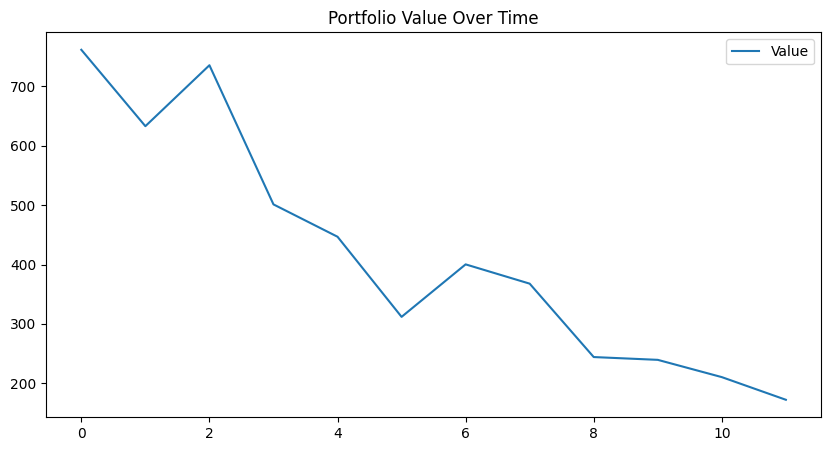

In [99]:
# Plot the portfolio values over time
portfolio_data = pd.DataFrame(portfolio_values, columns=['Value'])
portfolio_data.plot(figsize=(10,5), title='Portfolio Value Over Time')
# print portfolio
portfolio_df 